# About
This notebook generates two sets of figures:

1. Aligned experimental/computational scattering curves for the four Schuler sequences where SAXS data were reported
2. Comparison of STARLING-derived $R_g$ histograms with experimental average scattering value overlaid

## References
Holla, A., Martin, E. W., Dannenhoffer-Lafage, T., Ruff, K. M., König, S. L. B., Nüesch, M. F., Chowdhury, A., Louis, J. M., Soranno, A., Nettels, D., Pappu, R. V., Best, R. B., Mittag, T. & Schuler, B. Identifying sequence effects on chain dimensions of disordered proteins by integrating experiments and simulations. JACS Au 4, 4729–4743 (2024).
  


In [1]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import figure

import matplotlib as mpl

mpl.rcParams['xtick.major.pad'] = 1
mpl.rcParams['ytick.major.pad'] = 1

mpl.rcParams['xtick.major.size'] = 2  # Major tick length for x-axis
mpl.rcParams['xtick.minor.size'] = 0.5   # Minor tick length for x-axis
mpl.rcParams['ytick.major.size'] = 2  # Major tick length for y-axis
mpl.rcParams['ytick.minor.size'] = 0.5   # Minor tick length for y-axis

mpl.rcParams['xtick.major.width'] = 0.375  # Major tick width for x-axis
mpl.rcParams['ytick.major.width'] = 0.375  # Major tick width for y-axis
mpl.rcParams['xtick.minor.width'] = 0.375  # Major tick width for x-axis
mpl.rcParams['ytick.minor.width'] = 0.375  # Major tick width for y-axis


	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.375

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

font = {'family' : 'arial',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)


In [20]:
import pickle
def read_pickle(fn):
    """Reads a pickle file and returns the stored object."""
    with open(fn, "rb") as f:
        return pickle.load(f)

def write_pickle(fn, outdict):
    """Writes a dictionary (or any object) to a pickle file."""
    with open(fn, "wb") as f:
        pickle.dump(outdict, f, protocol=pickle.HIGHEST_PROTOCOL)    

# function for building nice smooth distance histograms
def get_histogram_vals(vals, bw=1, bmin=0,bmax=50, wl=10, polyorder=3):
    
    bins = np.arange(bmin,bmax,bw)
    [a,b]= np.histogram(vals,bins=bins)
    
    smoothed = savgol_filter(a,wl,polyorder)

    smoothed[smoothed<0]=0
    return b[1:]-bw*0.5, a, smoothed

# function for plotting nice smooth distance histograms
def plot_histo(n, fn, color):        
    figure(None, (1.2, 1.2), dpi=250)
    ax = plt.gca()
    bw=1
    X = get_histogram_vals(starling_rgs_all[n], bw=bw)
    plt.plot(X[0],X[2], color='k', lw=0.4)
    plt.fill_between(X[0], 0, X[2], alpha=0.2, color=color)
    plt.bar(X[0],X[1], width=bw*0.8, color=color,alpha=0.4, edgecolor='k',lw=0.1)
    plt.ylim([0,200])
    plt.xlim([10,45])
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.ylabel('count', fontsize=7)
    plt.xlabel('Rg (Å)', fontsize=7)
    plt.title(n, fontsize=4)
    ax.axvline(saxs_rg_values[n], color='k',lw=1, alpha=0.9)
    ax.axvline(np.mean(starling_rgs_all[n]), color=color,lw=1, alpha=0.7,ls='--')
    
    plt.tight_layout()
    plt.savefig(fn)        

In [13]:
 ## Initial pre-amble for making nice figures
import os
import numpy as np
import matplotlib
from scipy.signal import savgol_filter

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import string  
import protfasta

from starling import load_ensemble

REALIGN_WITH_HOUSETOOLS = True

In [14]:
# NB: we (holehouse lab) have an internal package which includes a set of internal
# tools called housetools; if we are running this internally, the following code allows
# us to rebuild the "aligned" curves from the ensembles. However, it's worth noting
# all this is code the aligns experimental an simulated scattering curves to ensure I(q)
# values match up, so nothing fancy! If you're regenerating the figures there is no need
# to do this the pre-aligned curves are provided as pickle files.
if REALIGN_WITH_HOUSETOOLS:
    from housetools.methods import saxs

In [16]:
#
# Define the names, sequences, and colors for the four SAXS sequences we're looking at here
#

names = ['dCh_minus', 'dTRBP', 'sNh_plus', 'sNrich']
seqs = {} 

seqs['dCh_minus'] = 'GSGSCMGLPTGMEEKEEGTDESEQKPVVQTPAQPDDSAEVDSAALDQAESAKQQGPILTKHGCTLGPR'
seqs['dTRBP'] = 'GSGSCLEPALEDSSSFSPLDSSLPEDIPVFTAAAAATPVPSVVLTRSPPMELQPPVSPQQSECTLGPR'
seqs['sNh_plus'] = 'GSGSCPEEIETRKKDRKNRREMLKRTSALQPAAPKPTHKKPVPKRNVGAERKSTINEDLLPPCTLGPR'
seqs['sNrich'] = 'GSGSCLDQEDNNGPLLIKTANNLIQNNSNMLPLNALHNAPPMHLNEGGISNMRVNDSLPSNTCTLGPR'

schuler_colors = {}
schuler_colors['dCh_minus'] = '#69F2F1'
schuler_colors['dTRBP'] = '#EA476F'
schuler_colors['sNh_plus'] = '#EACBFE'
schuler_colors['sNrich'] = '#C9F73D'



In [17]:
# IF we requested to recalculate the re-aligned experimental/computational curves, go for it, but
# this is not needed to reproduce the paper's figures.
if REALIGN_WITH_HOUSETOOLS:
    # build the aligned curves
    for idx, n in enumerate(names):
    
        # get the filename
        exp_file = f'saxs/{n}/{n}.dat'
        sim_file = f'saxs/{n}/average_curve.dat'
        
        # define parameters we use for aligning...
        qmin_fit = 0.01
        qmax_fit = 0.25
        
        d = saxs.fit_scattering_curves(exp_file, sim_file,qmin=qmin_fit, qmax=qmax_fit, verbose=False)
    
        write_pickle(f'saxs/scattering_curves/{n}.pkl', d)


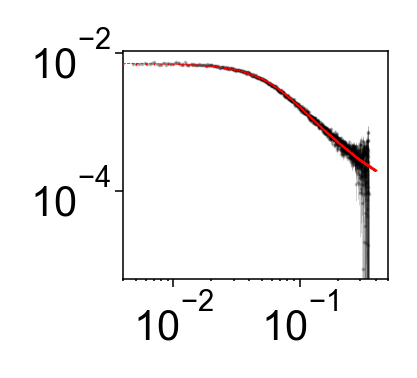

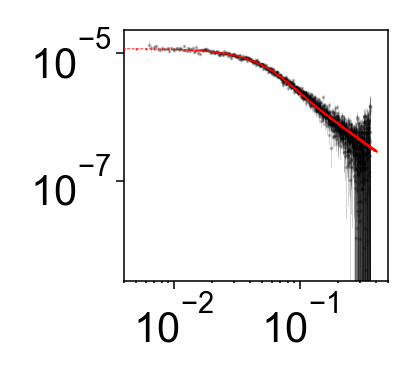

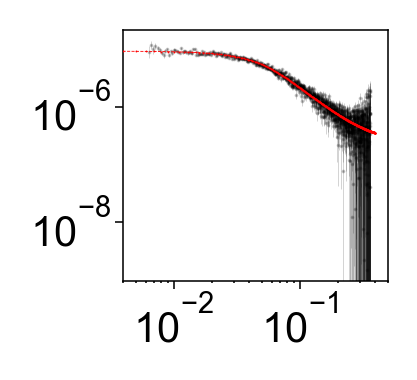

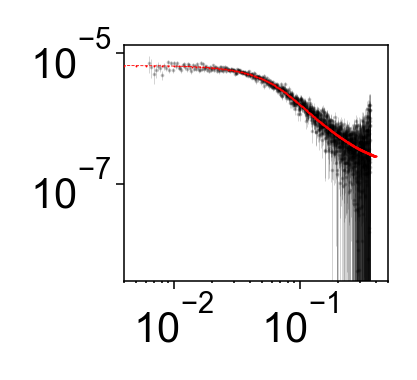

In [18]:
show_axes = False


for idx, n in enumerate(names):

    # size here VERY finely tuned to match figure
    figure(num=None, figsize=(1.5, 1.38), dpi=150, facecolor='w', edgecolor='k')
    ax = plt.gca()

    # load in the aligned scattering curves
    d = read_pickle(f'saxs/scattering_curves/{n}.pkl')
    
    # plot the aligned data
    plt.errorbar(d[0]['D1_q'], d[0]['D1_Iq'], yerr=d[0]['D1_Iq_error'], fmt='o', linewidth=0.2, markersize=0.5, color='k', mew=0.4, alpha=0.2)    
    plt.plot(d[0]['D2_q'], d[0]['D2_Iq'], '.--', linewidth=0.2, markersize=0.5, color='r', zorder=10, mew=0.2)

    if show_axes:
        plt.xlabel('q')
        plt.ylabel('I(q)')
    else:
        plt.xlabel('')
        plt.ylabel('')
        plt.xticks([])
        plt.yticks([])
    
    #plt.title(n + f" ch2: {ch2}")
    #plt.legend(['Experiment', 'Simulation'])
    plt.xlim([0.004, 0.5])

    plt.xscale('log')
    plt.yscale('log')

    plt.tight_layout()
    plt.savefig(f'figures/SAXS_{n}.pdf')

In [19]:
# rg values here from analyzing scattering curves using the MFF of Riback et al. 2017
saxs_rg_values={}
for n in names:
    saxs_rg_values[n] = float(np.loadtxt(f'saxs/{n}/mff_rg_{n}.csv'))
    
starling_rgs_all = {}

for k in seqs:
    e = load_ensemble(f'ensembles/{k}.starling')
    starling_rgs_all[k] = e.radius_of_gyration()
    

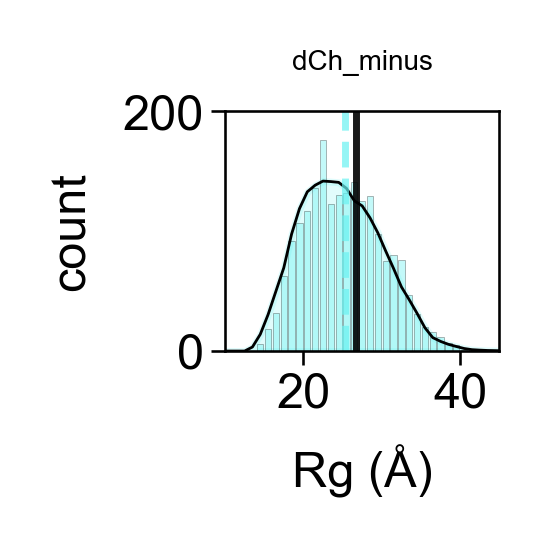

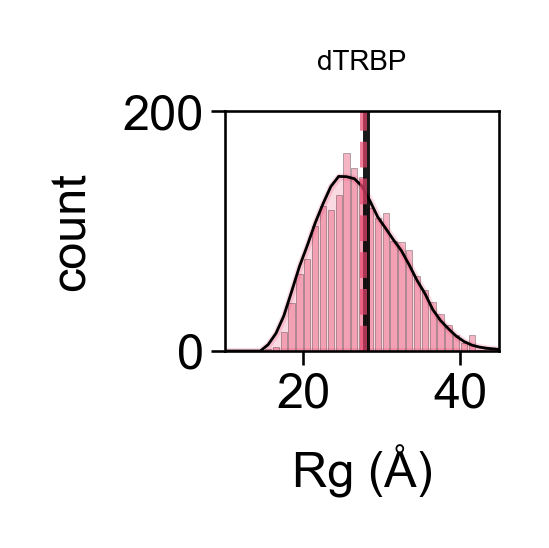

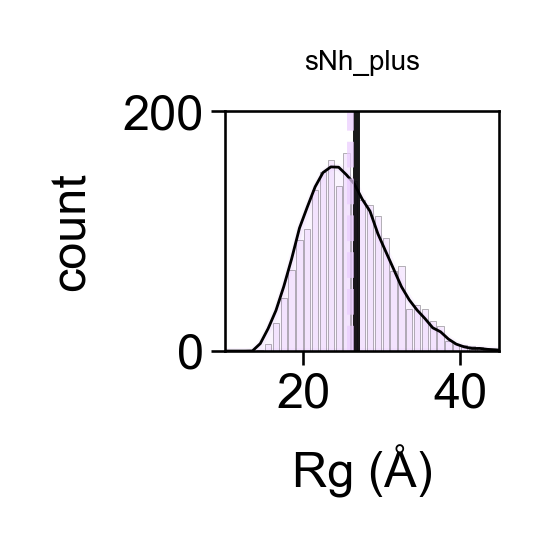

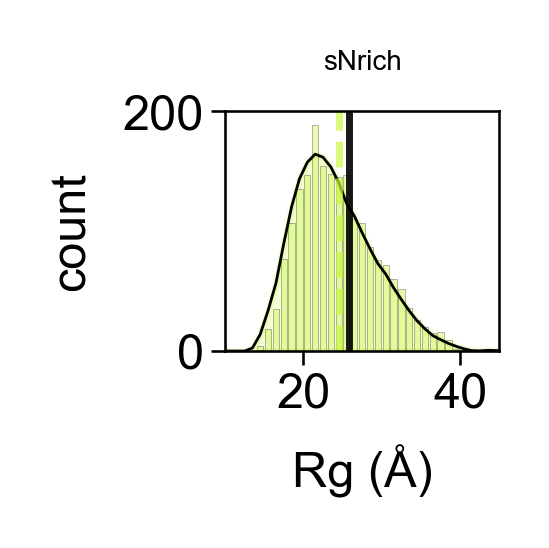

In [21]:
for n in seqs:    
    plot_histo(n,'figures/saxs_rg_dist_'+n+'.pdf', schuler_colors[n])
    
    